In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
signatures = pd.read_csv('../denoising/sliding_window_y.csv', index_col=0)
signals = pd.read_csv('../denoising/sliding_window_X.csv', index_col=0)

In [3]:
signals = np.asarray(signals)
signatures = np.asarray(signatures)
sample_length = 32

In [4]:
y = np.zeros((len(signatures),2))

for i in range(len(signatures)):
    pos = np.where(signatures[i] > 0)[0]
    if len(pos) > 0:
        y[i][0] += np.max([0, pos[0] - 1])
        y[i][1] += np.min([sample_length, pos[-1] + 1])

y /= sample_length

In [5]:
X = signals[:,:,np.newaxis]

mean = X.mean(axis=1).reshape((X.shape[0],1,1))
#mean = 0.0
X = X - mean
sd = X.std(axis=1).mean()
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X /= sd
print("Mean: ", X.mean())
print("Std: ", X.std())


Mean:  -7.99317374239e-17
Std:  1.21030715591


In [54]:
len(y[np.where(np.sum(y,axis=1) > 0)]) / len(y)

0.4491783634341055

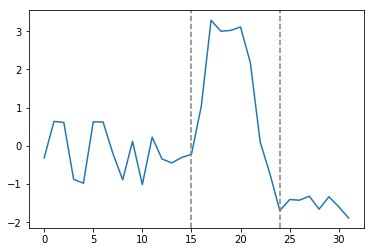

In [35]:
dice = np.random.randint(1000)

plt.plot(X[dice])
plt.axvline(y[dice][0]*sample_length, color='grey', ls='--')
plt.axvline(y[dice][1]*sample_length, color='grey', ls='--')
plt.show()

In [36]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

## Forcing tf to use the CPU
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [37]:
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from tqdm import tqdm


In [9]:
layer1 = Conv1D(filters=16, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='valid', strides=1)
layer2 = Conv1D(filters=16, kernel_size=4,activation='linear',padding='valid', strides=1)
layer2_b = Flatten()
layer3 = Dense(units=4096,activation='relu')
layer4 = Dense(units=3072,activation='relu')
layer5 = Dense(units=2048,activation='relu')
layer6 = Dense(units=512,activation='relu')
outputs = Dense(units=2,activation='linear')

model = Sequential()

model.add(layer1)
model.add(layer2)
model.add(layer2_b)
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(layer6)
model.add(outputs)

In [55]:

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['mae'])

training_history = model.fit(X, y, batch_size=64,verbose=1,epochs=1, validation_split=0.2)

Train on 391219 samples, validate on 97805 samples
Epoch 1/1
  2752/391219 [..............................] - ETA: 1:16:47 - loss: 0.1110 - mean_absolute_error: 0.23 - ETA: 59:22 - loss: 0.0680 - mean_absolute_error: 0.1711 - ETA: 54:14 - loss: 0.0538 - mean_absolute_error: 0.14 - ETA: 51:22 - loss: 0.0405 - mean_absolute_error: 0.11 - ETA: 49:48 - loss: 0.0325 - mean_absolute_error: 0.09 - ETA: 48:52 - loss: 0.0272 - mean_absolute_error: 0.08 - ETA: 49:04 - loss: 0.0234 - mean_absolute_error: 0.07 - ETA: 49:48 - loss: 0.0205 - mean_absolute_error: 0.06 - ETA: 50:01 - loss: 0.0182 - mean_absolute_error: 0.06 - ETA: 49:32 - loss: 0.0164 - mean_absolute_error: 0.05 - ETA: 49:15 - loss: 0.0149 - mean_absolute_error: 0.05 - ETA: 48:49 - loss: 0.0137 - mean_absolute_error: 0.04 - ETA: 48:34 - loss: 0.0127 - mean_absolute_error: 0.04 - ETA: 48:15 - loss: 0.0118 - mean_absolute_error: 0.04 - ETA: 48:04 - loss: 0.0110 - mean_absolute_error: 0.04 - ETA: 47:48 - loss: 0.0103 - mean_absolute_erro

KeyboardInterrupt: 

In [12]:
training_history.history

{'loss': [1.0691795520698755],
 'mean_absolute_error': [0.10615271424214918],
 'val_loss': [0.02389899192313269],
 'val_mean_absolute_error': [0.069124643048847162]}

In [14]:
model.save('rectangles.h5')

In [57]:
from keras.models import load_model

model = load_model('rectangles.h5')

In [69]:
pred = model.predict(X)*sample_length

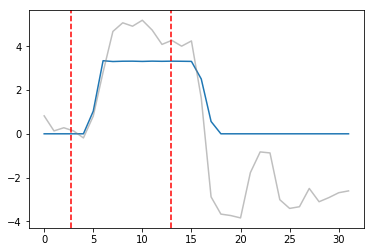

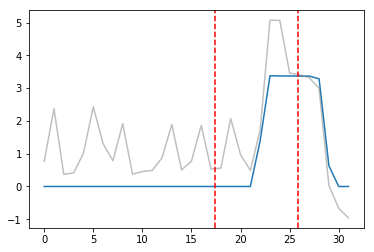

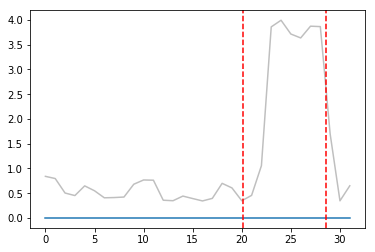

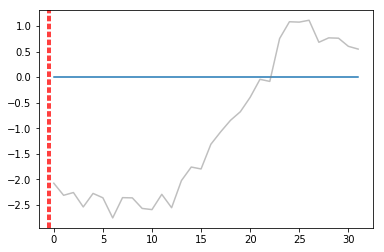

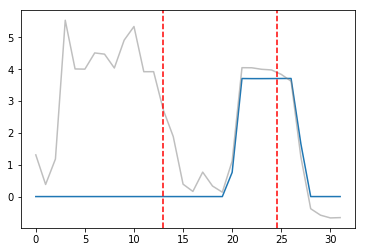

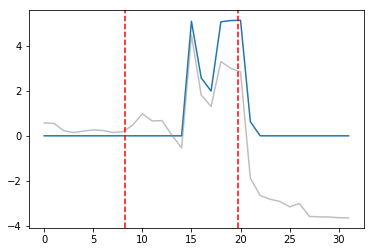

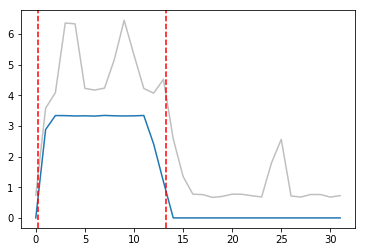

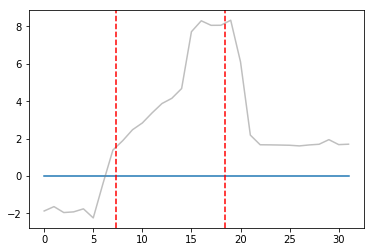

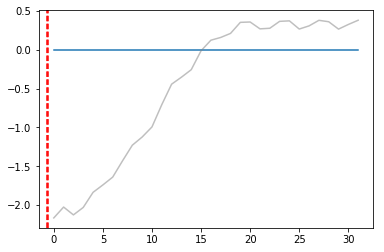

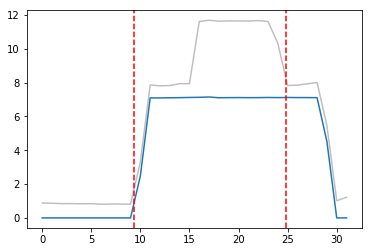

In [70]:
for i in range(10):
    dice = np.random.randint(len(X))
    plt.plot(signatures[dice])
    plt.plot(signals[dice], color='grey', alpha=0.5)
    plt.axvline(pred[dice][0], color='red', ls='--')
    plt.axvline(pred[dice][1], color='red', ls='--')
    plt.show()

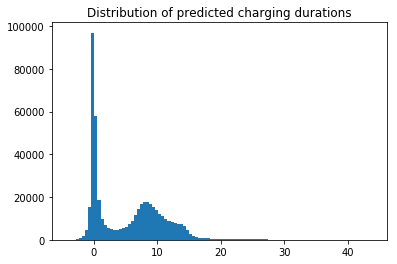

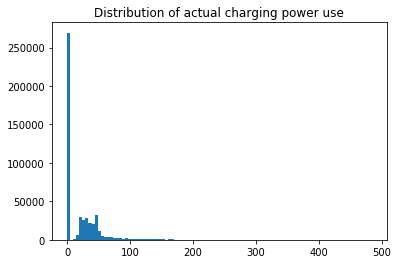

In [111]:
pred_diff = pred[:,1] - pred[:,0]
plt.title("Distribution of predicted charging durations")
plt.hist(pred_diff, bins=100)
plt.show()
plt.title("Distribution of actual charging power use")
plt.hist(np.sum(signatures, axis=1), bins=100)
plt.show()

In [106]:
pred_class = np.zeros(len(pred))
pred_class[np.where(pred_diff > 4)] += 1
truth_class = np.zeros(len(pred))
truth_class[np.where(np.sum(signatures,axis=1) > 0)] += 1

np.sum((pred_class - truth_class)**2) / len(pred)


0.10973899031540374

In [112]:
precision = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where((pred_class == 1))[0])
recall = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where(truth_class == 1)[0])
f1 = 2*precision*recall / (precision + recall)
acc = 1 - (np.sum((pred_class - truth_class)**2) / len(pred_class))
    
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Accuracy: ", acc)

Precision:  0.8249839459958964
Recall:  0.9591730819133293
F1:  0.8870322304950878
Accuracy:  0.890261009685


## Smaller network 
Since the charging signatures are very simple structures, the above network is most likely an overkill.

In [58]:
from keras.layers import Conv1D, Flatten
from keras.models import Sequential

layer1 = Conv1D(filters=16, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='valid', strides=1)
layer2_b = Flatten()
layer5 = Dense(units=512,activation='relu')
layer6 = Dense(units=256,activation='relu')
outputs = Dense(units=2,activation='linear', name='output')

model = Sequential()

model.add(layer1)
model.add(layer2_b)
model.add(layer5)
model.add(layer6)
model.add(outputs)

In [68]:
model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['mae'])

training_history = model.fit(X, y, batch_size=64,verbose=1,epochs=5, validation_split=0.1)

Train on 440121 samples, validate on 48903 samples
Epoch 1/5


 48000/440121 [==>...........................] - ETA: 28:15 - loss: 0.0210 - mean_absolute_error: 0.08 - ETA: 6:49 - loss: 4.5411 - mean_absolute_error: 1.1054 - ETA: 4:03 - loss: 2.3394 - mean_absolute_error: 0.679 - ETA: 3:09 - loss: 1.5828 - mean_absolute_error: 0.516 - ETA: 2:40 - loss: 1.2001 - mean_absolute_error: 0.429 - ETA: 2:29 - loss: 1.0093 - mean_absolute_error: 0.386 - ETA: 2:17 - loss: 0.8443 - mean_absolute_error: 0.348 - ETA: 2:11 - loss: 0.7474 - mean_absolute_error: 0.325 - ETA: 2:03 - loss: 0.6558 - mean_absolute_error: 0.304 - ETA: 1:57 - loss: 0.5855 - mean_absolute_error: 0.286 - ETA: 1:55 - loss: 0.5392 - mean_absolute_error: 0.274 - ETA: 1:52 - loss: 0.4998 - mean_absolute_error: 0.263 - ETA: 1:47 - loss: 0.4524 - mean_absolute_error: 0.251 - ETA: 1:44 - loss: 0.4202 - mean_absolute_error: 0.244 - ETA: 1:42 - loss: 0.3913 - mean_absolute_error: 0.235 - ETA: 1:43 - loss: 0.3761 - mean_absolute_error: 0.231 - ETA: 1:41 - loss: 0.3537 - mean_absolute_error: 0.225 

 97664/440121 [=====>........................] - ETA: 1:05 - loss: 0.0630 - mean_absolute_error: 0.122 - ETA: 1:05 - loss: 0.0627 - mean_absolute_error: 0.122 - ETA: 1:05 - loss: 0.0625 - mean_absolute_error: 0.122 - ETA: 1:05 - loss: 0.0623 - mean_absolute_error: 0.122 - ETA: 1:05 - loss: 0.0621 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0619 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0617 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0615 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0613 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0612 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0609 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0608 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0606 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0605 - mean_absolute_error: 0.121 - ETA: 1:05 - loss: 0.0603 - mean_absolute_error: 0.120 - ETA: 1:05 - loss: 0.0601 - mean_absolute_error: 0.120 - ETA: 1:05 - loss: 0.0599 - mean_absolute_error: 0.120 -

153600/440121 [=========>....................] - ETA: 56s - loss: 0.0451 - mean_absolute_error: 0.11 - ETA: 56s - loss: 0.0450 - mean_absolute_error: 0.11 - ETA: 56s - loss: 0.0450 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0449 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0448 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0447 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0447 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0446 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0445 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0445 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0444 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0444 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0443 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0443 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0442 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0442 - mean_absolute_error: 0.11 - ETA: 55s - loss: 0.0441 - mean_absolute_error: 0.11 - ETA: 54s - loss: 0.0441 - mean_ab

204672/440121 [============>.................] - ETA: 45s - loss: 0.0384 - mean_absolute_error: 0.10 - ETA: 45s - loss: 0.0384 - mean_absolute_error: 0.10 - ETA: 45s - loss: 0.0384 - mean_absolute_error: 0.10 - ETA: 45s - loss: 0.0384 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0383 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0383 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0383 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0383 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0382 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0382 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0382 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0381 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0381 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0381 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0381 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0381 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0380 - mean_absolute_error: 0.10 - ETA: 44s - loss: 0.0380 - mean_ab

258496/440121 [================>.............] - ETA: 37s - loss: 0.0355 - mean_absolute_error: 0.10 - ETA: 37s - loss: 0.0355 - mean_absolute_error: 0.10 - ETA: 37s - loss: 0.0355 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0355 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0355 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0354 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0353 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0353 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0353 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0353 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0352 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0352 - mean_absolute_error: 0.10 - ETA: 36s - loss: 0.0352 - mean_ab

313984/440121 [====================>.........] - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 28s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0334 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_absolute_error: 0.10 - ETA: 27s - loss: 0.0333 - mean_ab

366464/440121 [=======================>......] - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0320 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 19s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_absolute_error: 0.09 - ETA: 18s - loss: 0.0319 - mean_ab

423424/440121 [===========================>..] - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 11s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0310 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0309 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0309 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0309 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0309 - mean_absolute_error: 0.09 - ETA: 10s - loss: 0.0309 - mean_ab

440121/440121 [==============================] - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 2s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0302 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0301 - mean_absolute_error: 0.096 - ETA: 1s - loss: 0.0301 - mean_abs

 54464/440121 [==>...........................] - ETA: 2:45 - loss: 0.0193 - mean_absolute_error: 0.084 - ETA: 1:37 - loss: 0.0251 - mean_absolute_error: 0.091 - ETA: 1:35 - loss: 0.0257 - mean_absolute_error: 0.090 - ETA: 1:31 - loss: 0.0239 - mean_absolute_error: 0.087 - ETA: 1:27 - loss: 0.0247 - mean_absolute_error: 0.089 - ETA: 1:25 - loss: 0.0244 - mean_absolute_error: 0.088 - ETA: 1:22 - loss: 0.0248 - mean_absolute_error: 0.089 - ETA: 1:22 - loss: 0.0244 - mean_absolute_error: 0.089 - ETA: 1:20 - loss: 0.0247 - mean_absolute_error: 0.089 - ETA: 1:17 - loss: 0.0240 - mean_absolute_error: 0.088 - ETA: 1:15 - loss: 0.0244 - mean_absolute_error: 0.088 - ETA: 1:14 - loss: 0.0242 - mean_absolute_error: 0.088 - ETA: 1:12 - loss: 0.0240 - mean_absolute_error: 0.087 - ETA: 1:11 - loss: 0.0244 - mean_absolute_error: 0.088 - ETA: 1:10 - loss: 0.0245 - mean_absolute_error: 0.088 - ETA: 1:09 - loss: 0.0244 - mean_absolute_error: 0.088 - ETA: 1:08 - loss: 0.0243 - mean_absolute_error: 0.088 -

108032/440121 [======>.......................] - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0242 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 56s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_absolute_error: 0.08 - ETA: 55s - loss: 0.0241 - mean_ab

164416/440121 [==========>...................] - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0240 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0240 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 49s - loss: 0.0240 - mean_absolute_error: 0.08 - ETA: 48s - loss: 0.0240 - mean_absolute_error: 0.08 - ETA: 48s - loss: 0.0240 - mean_absolute_error: 0.08 - ETA: 48s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 48s - loss: 0.0240 - mean_ab

207104/440121 [=============>................] - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 40s - loss: 0.0239 - mean_ab

249984/440121 [================>.............] - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 36s - loss: 0.0239 - mean_ab

293440/440121 [===================>..........] - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 31s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 30s - loss: 0.0238 - mean_ab

333824/440121 [=====================>........] - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0238 - mean_ab

375040/440121 [========================>.....] - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 18s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0239 - mean_ab

418176/440121 [===========================>..] - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0239 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_absolute_error: 0.08 - ETA: 10s - loss: 0.0238 - mean_ab

440121/440121 [==============================] - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.085 - ETA: 3s - loss: 0.0238 - mean_absolute_error: 0.086 - ETA: 3s - loss: 0.0238 - mean_abs

 42880/440121 [=>............................] - ETA: 4:15 - loss: 0.0266 - mean_absolute_error: 0.089 - ETA: 1:47 - loss: 0.0224 - mean_absolute_error: 0.082 - ETA: 1:32 - loss: 0.0243 - mean_absolute_error: 0.085 - ETA: 1:27 - loss: 0.0250 - mean_absolute_error: 0.087 - ETA: 1:29 - loss: 0.0239 - mean_absolute_error: 0.085 - ETA: 1:28 - loss: 0.0235 - mean_absolute_error: 0.084 - ETA: 1:25 - loss: 0.0234 - mean_absolute_error: 0.084 - ETA: 1:26 - loss: 0.0239 - mean_absolute_error: 0.084 - ETA: 1:25 - loss: 0.0234 - mean_absolute_error: 0.084 - ETA: 1:23 - loss: 0.0238 - mean_absolute_error: 0.085 - ETA: 1:23 - loss: 0.0238 - mean_absolute_error: 0.084 - ETA: 1:22 - loss: 0.0239 - mean_absolute_error: 0.084 - ETA: 1:21 - loss: 0.0239 - mean_absolute_error: 0.085 - ETA: 1:22 - loss: 0.0238 - mean_absolute_error: 0.084 - ETA: 1:22 - loss: 0.0237 - mean_absolute_error: 0.084 - ETA: 1:22 - loss: 0.0236 - mean_absolute_error: 0.084 - ETA: 1:21 - loss: 0.0240 - mean_absolute_error: 0.084 -

 83136/440121 [====>.........................] - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:15 - loss: 0.0228 - mean_absolute_error: 0.083 -

123136/440121 [=======>......................] - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:10 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0228 - mean_absolute_error: 0.083 -

165952/440121 [==========>...................] - ETA: 1:02 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0228 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:02 - loss: 0.0229 - mean_absolute_error: 0.083 - ETA: 1:01 - loss: 0.0229 - mean_absolute_error: 0.083 -

210816/440121 [=============>................] - ETA: 54s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 54s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 54s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 53s - loss: 0.0229 - mean_ab

258944/440121 [================>.............] - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 44s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0228 - mean_ab

307200/440121 [===================>..........] - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 33s - loss: 0.0228 - mean_ab

355200/440121 [=======================>......] - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 24s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 23s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 23s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 23s - loss: 0.0228 - mean_absolute_error: 0.08 - ETA: 23s - loss: 0.0228 - mean_ab

401408/440121 [==========================>...] - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 15s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_absolute_error: 0.08 - ETA: 14s - loss: 0.0229 - mean_ab

440121/440121 [==============================] - ETA: 7s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 7s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 7s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_absolute_error: 0.082 - ETA: 6s - loss: 0.0228 - mean_abs

 42240/440121 [=>............................] - ETA: 3:16 - loss: 0.0215 - mean_absolute_error: 0.082 - ETA: 1:32 - loss: 0.0233 - mean_absolute_error: 0.080 - ETA: 1:26 - loss: 0.0222 - mean_absolute_error: 0.079 - ETA: 1:22 - loss: 0.0229 - mean_absolute_error: 0.081 - ETA: 1:23 - loss: 0.0223 - mean_absolute_error: 0.080 - ETA: 1:21 - loss: 0.0226 - mean_absolute_error: 0.081 - ETA: 1:20 - loss: 0.0211 - mean_absolute_error: 0.078 - ETA: 1:20 - loss: 0.0207 - mean_absolute_error: 0.077 - ETA: 1:20 - loss: 0.0205 - mean_absolute_error: 0.077 - ETA: 1:20 - loss: 0.0206 - mean_absolute_error: 0.077 - ETA: 1:20 - loss: 0.0211 - mean_absolute_error: 0.078 - ETA: 1:19 - loss: 0.0216 - mean_absolute_error: 0.079 - ETA: 1:19 - loss: 0.0216 - mean_absolute_error: 0.079 - ETA: 1:19 - loss: 0.0218 - mean_absolute_error: 0.080 - ETA: 1:18 - loss: 0.0217 - mean_absolute_error: 0.079 - ETA: 1:18 - loss: 0.0216 - mean_absolute_error: 0.080 - ETA: 1:18 - loss: 0.0214 - mean_absolute_error: 0.079 -

 84288/440121 [====>.........................] - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:16 - loss: 0.0220 - mean_absolute_error: 0.080 -

127232/440121 [=======>......................] - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:08 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:07 - loss: 0.0220 - mean_absolute_error: 0.080 -

171456/440121 [==========>...................] - ETA: 1:00 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:00 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 1:00 - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.080 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 59s - loss: 0.0221 - 

214016/440121 [=============>................] - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 51s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 50s - loss: 0.0222 - mean_ab

256128/440121 [================>.............] - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 43s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 42s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 42s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 42s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 42s - loss: 0.0222 - mean_ab

300544/440121 [===================>..........] - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 35s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 34s - loss: 0.0221 - mean_ab

348416/440121 [======================>.......] - ETA: 27s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 27s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0221 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 26s - loss: 0.0222 - mean_ab

397632/440121 [==========================>...] - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 17s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_absolute_error: 0.08 - ETA: 16s - loss: 0.0222 - mean_ab

440121/440121 [==============================] - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 7s - loss: 0.0222 - mean_absolute_error: 0.080 - ETA: 6s - loss: 0.0222 - mean_abs

 43776/440121 [=>............................] - ETA: 3:40 - loss: 0.0135 - mean_absolute_error: 0.070 - ETA: 1:27 - loss: 0.0229 - mean_absolute_error: 0.082 - ETA: 1:21 - loss: 0.0241 - mean_absolute_error: 0.084 - ETA: 1:16 - loss: 0.0237 - mean_absolute_error: 0.084 - ETA: 1:15 - loss: 0.0242 - mean_absolute_error: 0.087 - ETA: 1:12 - loss: 0.0230 - mean_absolute_error: 0.084 - ETA: 1:11 - loss: 0.0233 - mean_absolute_error: 0.084 - ETA: 1:10 - loss: 0.0224 - mean_absolute_error: 0.083 - ETA: 1:09 - loss: 0.0219 - mean_absolute_error: 0.082 - ETA: 1:08 - loss: 0.0219 - mean_absolute_error: 0.081 - ETA: 1:09 - loss: 0.0221 - mean_absolute_error: 0.081 - ETA: 1:09 - loss: 0.0222 - mean_absolute_error: 0.081 - ETA: 1:10 - loss: 0.0216 - mean_absolute_error: 0.080 - ETA: 1:11 - loss: 0.0216 - mean_absolute_error: 0.080 - ETA: 1:12 - loss: 0.0214 - mean_absolute_error: 0.079 - ETA: 1:11 - loss: 0.0218 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0215 - mean_absolute_error: 0.080 -

 87488/440121 [====>.........................] - ETA: 1:11 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:11 - loss: 0.0219 - mean_absolute_error: 0.079 - ETA: 1:11 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:11 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:10 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:09 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:09 - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 1:09 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:09 - loss: 0.0218 - mean_absolute_error: 0.080 - ETA: 1:09 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:09 - loss: 0.0219 - mean_absolute_error: 0.080 -

129856/440121 [=======>......................] - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0219 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:04 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:03 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:03 - loss: 0.0220 - mean_absolute_error: 0.080 - ETA: 1:03 - loss: 0.0220 - mean_absolute_error: 0.080 -

172352/440121 [==========>...................] - ETA: 58s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 58s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 57s - loss: 0.0218 - mean_ab

214336/440121 [=============>................] - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 50s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 49s - loss: 0.0218 - mean_ab

259008/440121 [================>.............] - ETA: 43s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 43s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 42s - loss: 0.0218 - mean_ab

305344/440121 [===================>..........] - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 34s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0217 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 33s - loss: 0.0218 - mean_ab

350912/440121 [======================>.......] - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 25s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 24s - loss: 0.0218 - mean_ab

392320/440121 [=========================>....] - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_absolute_error: 0.07 - ETA: 16s - loss: 0.0218 - mean_ab

434944/440121 [============================>.] - ETA: 9s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 9s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 8s - loss: 0.0218 - mean_abs

440121/440121 [==============================] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.079 - ETA: 0s - loss: 0.0218 - mean_abs

In [69]:
model.save('rectangles_small.h5')
training_history.history

{'loss': [0.030024719350032935,
  0.023741505988777587,
  0.022832377079337534,
  0.022265793054396601,
  0.02181518397068195],
 'mean_absolute_error': [0.096343340346146847,
  0.085874703730525734,
  0.082799551864029278,
  0.080996353437367274,
  0.07963929998708115],
 'val_loss': [0.029661048586039768,
  0.030335999267843142,
  0.028496873752890031,
  0.028713838784330922,
  0.029033443761144175],
 'val_mean_absolute_error': [0.084273034122014187,
  0.081924314330842421,
  0.078126744360192998,
  0.077882283898799656,
  0.077900225134244994]}

In [70]:
pred = model.predict(X)*sample_length

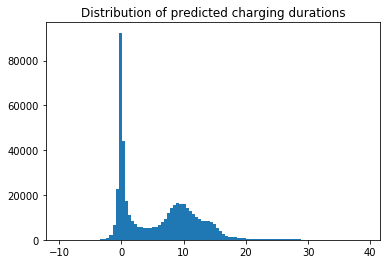

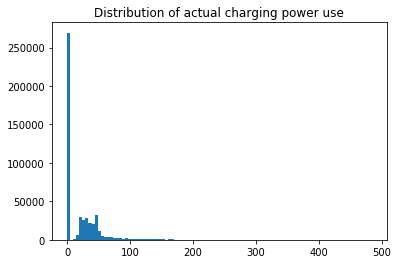

In [71]:
pred_diff = pred[:,1] - pred[:,0]
plt.title("Distribution of predicted charging durations")
plt.hist(pred_diff, bins=100)
plt.show()
plt.title("Distribution of actual charging power use")
plt.hist(np.sum(signatures, axis=1), bins=100)
plt.show()

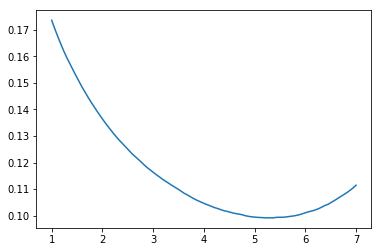

In [72]:
accs = []

for t in np.linspace(1,7,100):
    pred_class = np.zeros(len(pred))
    pred_class[np.where(pred_diff > t)] += 1
    truth_class = np.zeros(len(pred))
    truth_class[np.where(np.sum(signatures,axis=1) > 0)] += 1

    accs.append(np.sum((pred_class - truth_class)**2) / len(pred))

plt.plot(np.linspace(1,7,100),accs)
plt.show()

In [73]:
t = np.linspace(1,7,100)[np.argmin(accs)]
pred_class = np.zeros(len(pred))
pred_class[np.where(pred_diff > t)] += 1
truth_class = np.zeros(len(pred))
truth_class[np.where(np.sum(signatures,axis=1) > 0)] += 1

In [74]:
precision = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where((pred_class == 1))[0])
recall = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where(truth_class == 1)[0])
f1 = 2*precision*recall / (precision + recall)
acc = 1 - (np.sum((pred_class - truth_class)**2) / len(pred_class))
    
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Accuracy: ", acc)

Precision:  0.8512403138954557
Recall:  0.9442044259511333
F1:  0.8953156330467702
Accuracy:  0.90082081861


<function keras.activations.sigmoid>